In [ ]:
import warnings                                 
warnings.filterwarnings('ignore')


import numpy as np                         
import pandas as pd                          
import matplotlib.pyplot as plt            
import seaborn as sns                        

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize        

import statsmodels.formula.api as smf           
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                   
from tqdm import tqdm_notebook


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.dates as dates
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime as dt
import warnings 
import glob
warnings.filterwarnings("ignore")



In [ ]:
df=pd.read_csv("/Final_Day.csv")
price="Day-ahead Price [EUR/MWh]"


# apply interpolation to create continuity in dataset 
df = df.interpolate(method="cubic")

# remove spaces from string right and left sie " xxx " -> "xxx"
df['MTU (CET)'] = df['MTU (CET)'].apply(lambda x: x.strip())

# converts dataframe column "cet_timestampe" to datetime
df['MTU (CET)'] = df['MTU (CET)'].apply(lambda x: 
                                    dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

df = df.set_index("MTU (CET)") 


df_size = len(df[-12130:])*0.93 # take 95 of the data starting from 17538
# splitting data to train and test
df_train, df_test = df[:int(df_size)], df[int(df_size):]
print(df_train.shape) 
print(df_test.shape)


print(df)

(11280, 1)
(8472, 1)
                     Day-ahead Price [EUR/MWh]
MTU (CET)                                     
2018-01-01 00:00:00                       6.74
2018-01-01 01:00:00                       4.74
2018-01-01 02:00:00                       3.66
2018-01-01 03:00:00                       1.26
2018-01-01 04:00:00                     -20.10
...                                        ...
2020-04-02 19:00:00                      25.82
2020-04-02 20:00:00                      27.30
2020-04-02 21:00:00                      24.47
2020-04-02 22:00:00                      25.00
2020-04-02 23:00:00                      24.50

[19752 rows x 1 columns]


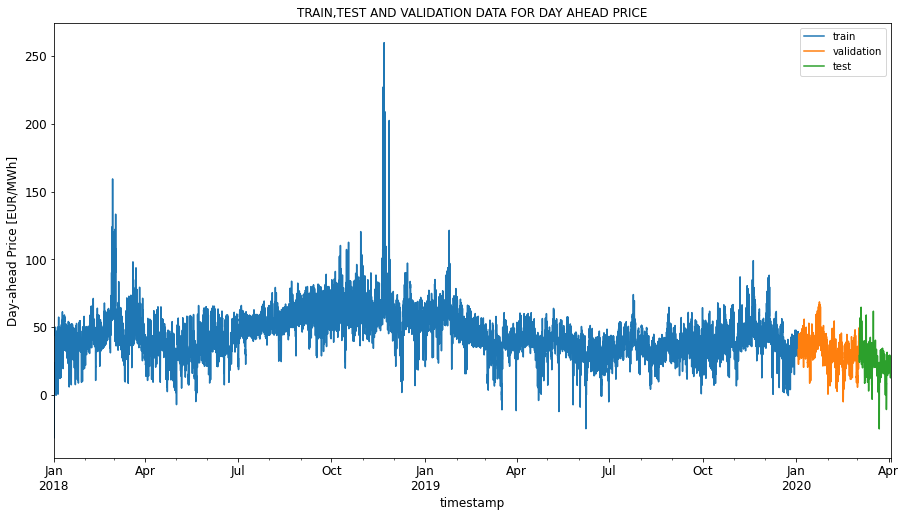

In [ ]:
df_valid_start = '2020-01-02 23:00:00'
df_test_start = '2020-03-02 23:00:00'
df[df.index <df_valid_start][['Day-ahead Price [EUR/MWh]']].rename(columns={'Day-ahead Price [EUR/MWh]':'train'}) \
    .join(df[(df.index >=df_valid_start) & (df.index <df_test_start)][['Day-ahead Price [EUR/MWh]']] \
          .rename(columns={'Day-ahead Price [EUR/MWh]':'validation'}), how='outer') \
    .join(df[df_test_start:][['Day-ahead Price [EUR/MWh]']].rename(columns={'Day-ahead Price [EUR/MWh]':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.title("TRAIN,TEST AND VALIDATION DATA FOR DAY AHEAD PRICE")
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Day-ahead Price [EUR/MWh]', fontsize=12)
plt.legend()
plt.show()



In [ ]:
T = 10
HORIZON = 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# 1. Get the train data from the correct data range
train = df.copy()[df.index < df_valid_start][['Day-ahead Price [EUR/MWh]']]


# 2. Scale data to be in range (0, 1). 
#   This transformation should be calibrated on the training set only. 
#   This is to prevent information from the validation or test sets 
#   leaking into the training data.
scaler = MinMaxScaler()
train['Day-ahead Price [EUR/MWh]'] = scaler.fit_transform(train)

# 3. Shift the dataframe to create the input samples.
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['Day-ahead Price [EUR/MWh]'].shift(-1, freq='H')
for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted['Day-ahead Price [EUR/MWh]'].shift(T-t, freq='H')
y_col = 'y_t+1'
X_cols = ['price_t-9','price_t-8','price_t-7','price_t-6','price_t-5',
             'price_t-4',
             'price_t-3',
             'price_t-2',
             'price_t-1',
             'price_t']
train_shifted.columns = ['price_original']+[y_col]+X_cols

# 4.Discard any samples with missing values
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,price_original,y_t+1,price_t-9,price_t-8,price_t-7,price_t-6,price_t-5,price_t-4,price_t-3,price_t-2,price_t-1,price_t
MTU (CET),,,,,,,,,,,,
2018-01-01 09:00:00,0.116016,0.055900,0.132159,0.125304,0.121603,0.113377,0.040169,0.000000,0.010830,0.062069,0.094869,0.116016
2018-01-01 10:00:00,0.055900,0.107619,0.125304,0.121603,0.113377,0.040169,0.000000,0.010830,0.062069,0.094869,0.116016,0.055900
2018-01-01 11:00:00,0.107619,0.116941,0.121603,0.113377,0.040169,0.000000,0.010830,0.062069,0.094869,0.116016,0.055900,0.107619
2018-01-01 12:00:00,0.116941,0.116941,0.113377,0.040169,0.000000,0.010830,0.062069,0.094869,0.116016,0.055900,0.107619,0.116941
2018-01-01 13:00:00,0.116941,0.126195,0.040169,0.000000,0.010830,0.062069,0.094869,0.116016,0.055900,0.107619,0.116941,0.116941


In [ ]:
y_train = train_shifted[y_col].values
X_train = train_shifted[X_cols].values


In [ ]:

# This is an important step to reshape the X into 3 dimension array
X_train = X_train.reshape(X_train.shape[0], T, 1)


In [ ]:
# 1. Get the validation data from the correct data range
look_back = dt.datetime.strptime(df_valid_start, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back) & (df.index < df_test_start)][['Day-ahead Price [EUR/MWh]']]

# 2. Scale the series using the transformer fitted on the training set:
valid['Day-ahead Price [EUR/MWh]'] = scaler.transform(valid)

# 3. Shift the dataframe to create the input samples
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['Day-ahead Price [EUR/MWh]'].shift(-1, freq='H')
for t in range(1, T+1):
    valid_shifted['price_t-'+str(T-t)] = valid_shifted['Day-ahead Price [EUR/MWh]'].shift(T-t, freq='H')
    
# 4.Discard any samples with missing values
valid_shifted = valid_shifted.dropna(how='any')
valid_shifted.head(3)

,Day-ahead Price [EUR/MWh],y+1,price_t-9,price_t-8,price_t-7,price_t-6,price_t-5,price_t-4,price_t-3,price_t-2,price_t-1,price_t-0
MTU (CET),,,,,,,,,,,,
2020-01-02 23:00:00,0.223498,0.218905,0.260068,0.259657,0.261130,0.266888,0.269185,0.267094,0.258834,0.228193,0.222230,0.223498
2020-01-03 00:00:00,0.218905,0.214450,0.259657,0.261130,0.266888,0.269185,0.267094,0.258834,0.228193,0.222230,0.223498,0.218905
2020-01-03 01:00:00,0.214450,0.208555,0.261130,0.266888,0.269185,0.267094,0.258834,0.228193,0.222230,0.223498,0.218905,0.214450


In [ ]:
# 5.Transform this Pandas dataframe into a numpy array
y_valid = valid_shifted['y+1'].values
X_valid = valid_shifted[['price_t-'+str(T-t) for t in range(1, T+1)]].values
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

In [ ]:
y_train.shape

(17557,)

In [ ]:

y_train[:3]

array([0.0559002 , 0.10761901, 0.11694143])

In [ ]:

X_train.shape

(17557, 10, 1)

In [ ]:
X_train[:3]

array([[[0.13215889],
        [0.12530418],
        [0.12160263],
        [0.11337698],
        [0.04016863],
        [0.        ],
        [0.01083045],
        [0.06206944],
        [0.09486925],
        [0.11601604]],

       [[0.12530418],
        [0.12160263],
        [0.11337698],
        [0.04016863],
        [0.        ],
        [0.01083045],
        [0.06206944],
        [0.09486925],
        [0.11601604],
        [0.0559002 ]],

       [[0.12160263],
        [0.11337698],
        [0.04016863],
        [0.        ],
        [0.01083045],
        [0.06206944],
        [0.09486925],
        [0.11601604],
        [0.0559002 ],
        [0.10761901]]])

In [ ]:
train_shifted.head(3)

,price_original,y_t+1,price_t-9,price_t-8,price_t-7,price_t-6,price_t-5,price_t-4,price_t-3,price_t-2,price_t-1,price_t
MTU (CET),,,,,,,,,,,,
2018-01-01 09:00:00,0.116016,0.055900,0.132159,0.125304,0.121603,0.113377,0.040169,0.000000,0.010830,0.062069,0.094869,0.116016
2018-01-01 10:00:00,0.055900,0.107619,0.125304,0.121603,0.113377,0.040169,0.000000,0.010830,0.062069,0.094869,0.116016,0.055900
2018-01-01 11:00:00,0.107619,0.116941,0.121603,0.113377,0.040169,0.000000,0.010830,0.062069,0.094869,0.116016,0.055900,0.107619


In [ ]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [ ]:
LATENT_DIM = 5 # number of units in the RNN layer
BATCH_SIZE = 64 # number of samples per mini-batch
EPOCHS = 100 # maximum number of times the training algorithm will cycle through all samples

In [ ]:

model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [ ]:
model.compile(optimizer='RMSprop', loss='mse')

In [ ]:

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 105       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


In [ ]:

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [ ]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

Train on 17557 samples, validate on 1439 samples
Epoch 1/100
17557/17557 [==============================] - 2s 131us/step - loss: 0.0160 - val_loss: 0.0015
Epoch 2/100
17557/17557 [==============================] - 2s 104us/step - loss: 0.0013 - val_loss: 6.0838e-04
Epoch 3/100
17557/17557 [==============================] - 2s 104us/step - loss: 9.0855e-04 - val_loss: 4.4716e-04
Epoch 4/100
17557/17557 [==============================] - 2s 105us/step - loss: 6.8322e-04 - val_loss: 3.4321e-04
Epoch 5/100
17557/17557 [==============================] - 2s 104us/step - loss: 5.3068e-04 - val_loss: 2.8020e-04
Epoch 6/100
17557/17557 [==============================] - 2s 103us/step - loss: 4.3397e-04 - val_loss: 2.3356e-04
Epoch 7/100
17557/17557 [==============================] - 2s 115us/step - loss: 3.7508e-04 - val_loss: 2.6149e-04
Epoch 8/100
17557/17557 [==============================] - 2s 112us/step - loss: 3.4114e-04 - val_loss: 2.2753e-04
Epoch 9/100
17557/17557 [==================

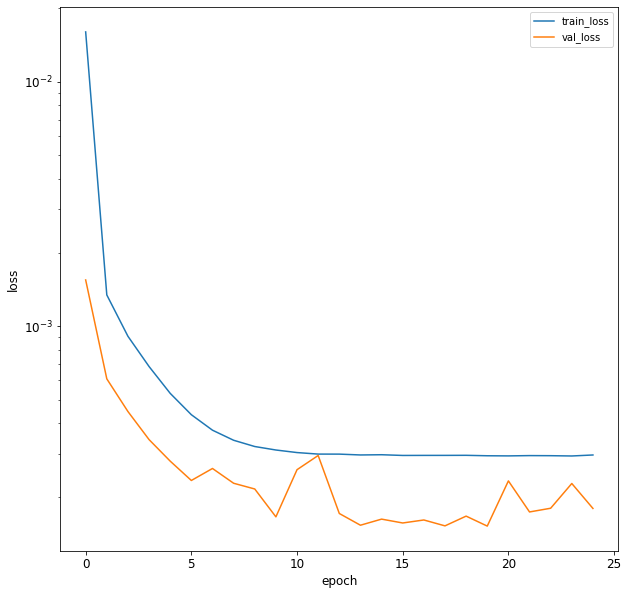

In [ ]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [ ]:
# 1. Get the test data from the correct data range
look_back_dt = dt.datetime.strptime(df_test_start, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = df.copy()[df_test_start:][['Day-ahead Price [EUR/MWh]']]
test.head()
test['Day-ahead Price [EUR/MWh]'] = scaler.transform(test)

test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['Day-ahead Price [EUR/MWh]'].shift(-1, freq='H')
for t in range(1, T+1):
    test_shifted['price_t-'+str(T-t)] = test_shifted['Day-ahead Price [EUR/MWh]'].shift(T-t, freq='H')
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted['y_t+1'].values
X_test = test_shifted[['price_t-'+str(T-t) for t in range(1, T+1)]].values
X_test = X_test[... , np.newaxis]



In [ ]:

predictions = model.predict(X_test)
predictions

array([[0.2692453 ],
       [0.24708028],
       [0.2376457 ],
       [0.23791397],
       [0.24331899],
       [0.23317038],
       [0.23790063],
       [0.24532206],
       [0.25214586],
       [0.25739324],
       [0.32097194],
       [0.30244547],
       [0.22527546],
       [0.24342789],
       [0.23435116],
       [0.21724689],
       [0.2180641 ],
       [0.21054074],
       [0.20776607],
       [0.20788048],
       [0.20774782],
       [0.22229831],
       [0.24694084],
       [0.28596562],
       [0.30436   ],
       [0.27218416],
       [0.2534792 ],
       [0.25120327],
       [0.24038835],
       [0.2353862 ],
       [0.23390158],
       [0.23893596],
       [0.25384787],
       [0.25927708],
       [0.360783  ],
       [0.31799453],
       [0.22600603],
       [0.23825195],
       [0.23169677],
       [0.22198819],
       [0.21782577],
       [0.21469267],
       [0.19880475],
       [0.19687039],
       [0.19293441],
       [0.19854482],
       [0.23973437],
       [0.283

In [ ]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2020-03-03 08:00:00,t+1,46.737700,41.68
1,2020-03-03 09:00:00,t+1,40.270614,37.97
2,2020-03-03 10:00:00,t+1,37.517886,36.49
3,2020-03-03 11:00:00,t+1,37.596158,37.32
4,2020-03-03 12:00:00,t+1,39.173182,35.56


In [ ]:

# %load -s mape common/utils.py
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()
    

In [ ]:

mape(eval_df['prediction'], eval_df['actual'])

-0.8673321667245237

In [ ]:
def mae(predictions,actuals):
  return (mean_absolute_error(predictions,actuals))

mae(eval_df['prediction'], eval_df['actual'])

3.2568746568101825

In [ ]:
def mse(predictions,actuals):
  return (mean_squared_error(predictions,actuals))

mse(eval_df['prediction'], eval_df['actual'])

19.356819013908204

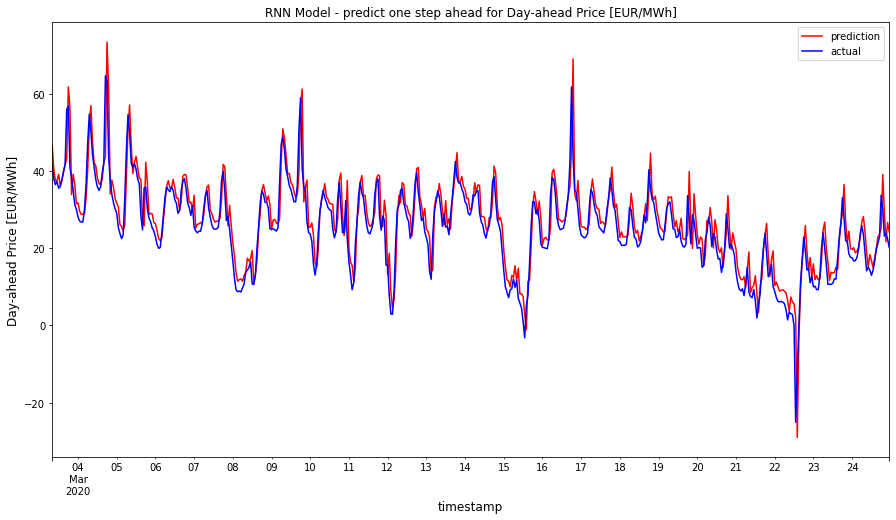

In [ ]:
eval_df[eval_df.timestamp<'2020-03-25'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.title("RNN Model - predict one step ahead for Day-ahead Price [EUR/MWh]")
plt.ylabel('Day-ahead Price [EUR/MWh]', fontsize=12)
plt.show()